In [114]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from itertools import islice

import matplotlib.pyplot as plt
import plotly.express as px

In [115]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
def get_embeddings(texts):
  return model.encode(texts)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

MPNetModel LOAD REPORT from: sentence-transformers/multi-qa-mpnet-base-dot-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [116]:
def get_pca(arr, n):
  pca = PCA(n_components=n)
  embeds_transform = pca.fit_transform(arr)
  return pca, embeds_transform

In [117]:
# Load the dataset to a dataframe
df_orig = pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/atis_intents_train.csv', names=['intent','query'])

# Take a small sample for illustration purposes
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df = df_orig[df_orig.intent.isin(sample_classes)].sample(frac=0.25, random_state=30)
df_orig = df_orig.drop(df.index)
df.reset_index(drop=True,inplace=True)

# Remove unnecessary column
intents = df['intent'] #save for a later need
df.drop(columns=['intent'], inplace=True)

In [118]:
# generate 786d text embeddings
embeds = get_embeddings(df['query'])
df['embeds'] = embeds.tolist()

In [119]:
# transform to 2d and 3d space
transform_2d, embeds_2d = get_pca(embeds, 2)
transform_3d, embeds_3d = get_pca(embeds, 3)
df['embeds_pca_2d'] = embeds_2d.tolist()
df['embeds_pca_3d'] = embeds_3d.tolist()

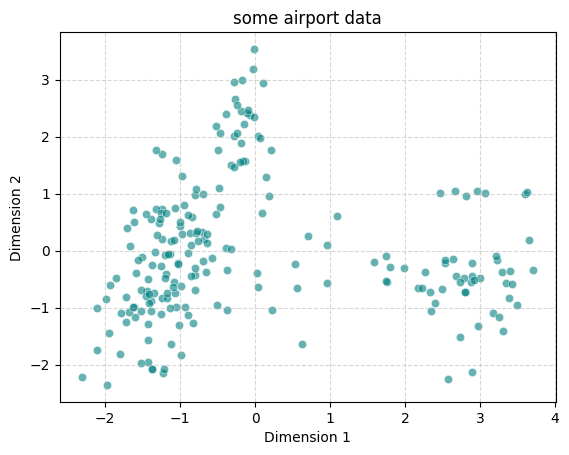

In [120]:
# visualize
matrix = np.stack(df['embeds_pca_2d'].values)

plt.scatter(matrix[:, 0], matrix[:, 1], alpha=0.6, edgecolors='w', linewidth=0.5, c='teal')
plt.title('some airport data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True, linestyle='--', alpha=0.5)

plt.savefig('scatterplog.png')

In [143]:
df[['x','y','z']] = pd.DataFrame(df['embeds_pca_3d'].tolist(), index=df.index)
fig = px.scatter_3d(df, x='x', y='y', z='z',
                    opacity=0.3,
                    hover_name='query',
                    hover_data={
                        'x': False,
                        'y': False,
                        'z': False
                    },
    title='some airport data')
fig.update_traces(marker=dict(size=4))
fig.show()

## Semantic Search
Now we will do semantic search on the vector space

In [122]:
def get_similarity(target, candidates):
  """
  Calculate cosine similarity between the search query and existing queries
  Exact search (population < 10,000)
  """
  # candidates = np.array(candidates)
  targets = np.expand_dims(np.array(target),axis=0)
  # Calculate cosine similarity
  sim = cosine_similarity(targets, candidates)
  sim = np.squeeze(sim).tolist()
  sort_index = np.argsort(sim)[::-1]
  sort_score = [sim[i] for i in sort_index]
  # combine the 2 lists so each element is a tuple
  similarity_scores = zip(sort_index,sort_score)
  return similarity_scores


In [144]:
# Define new query and get its embedding
new_query = "How can I find a taxi or a bus when the plane lands?"
new_query_embed = get_embeddings([new_query])[0]

matrix = np.stack(df['embeds'].values)
similarity = get_similarity(new_query_embed, matrix)

# View the top 10 matches
print('Query:')
print(new_query,'\n')

print('Most Similar Documents:')
for idx, sim in islice(similarity, 10):
    print(f'Similarity: {sim:.2f};', df.iloc[idx]['query'])

Query:
How can I find a taxi or a bus when the plane lands? 

Most Similar Documents:
Similarity: 0.60;  what kind of ground transportation can you offer me in seattle
Similarity: 0.58;  is there ground transportation from the milwaukee airport to the downtown area
Similarity: 0.58;  ground transportation please in the city of boston between airport and downtown
Similarity: 0.58;  is there ground transportation in boston from the airport
Similarity: 0.58;  how do i get downtown from the toronto airport
Similarity: 0.57;  can you help me with ground transportation information i need to get from the airport in philadelphia to downtown philadelphia
Similarity: 0.57;  is there ground transportation from the boston airport to downtown boston
Similarity: 0.57;  is there transportation from the atlanta airport to downtown atlanta
Similarity: 0.57;  show me ground transportation in dallas please
Similarity: 0.56;  in boston is there ground transportation between airport and downtown


In [145]:
# plot the query in the visualization
to_3d = transform_3d.transform(np.expand_dims(new_query_embed,axis=0))[0]
fig.add_scatter3d(
    x=[to_3d[0]],  # Must be a list, even for one point
    y=[to_3d[1]],
    z=[to_3d[2]],
    mode='markers',
    marker=dict(size=5, color='red'),
    text=[new_query],
    hoverinfo='text',
    name='Search Query' # Appears in the legend
)